# Homework 5 Solutions

In [95]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()


## Problem 1

In [96]:
def laxWendroffUpdate(u, sigma):
    return (
        0.5 * (sigma**2 + sigma) * np.roll(u, 1)
        + (1.0 - sigma**2) * u
        + 0.5 * (sigma**2 - sigma) * np.roll(u, -1)
    )


def beamWarmingUpdate(u, sigma):
    return (
        0.5 * sigma * (sigma - 1) * np.roll(u, 2)
        + sigma * (2.0 - sigma) * np.roll(u, 1)
        + 0.5 * (1.0 - sigma) * (2.0 - sigma) * u
    )


def solvePeriodicIVP(u0, sigma, numSteps, stepFunc):
    # Initialize the solution array (ignore right end node due to periodicity)
    u = u0.copy()[:-1]

    for _ in range(numSteps):
        u = stepFunc(u, sigma)

    return np.append(u, u[0])


def getInitCondition(x, L):
    return np.exp(-50 * (x / L - 0.5) ** 2)


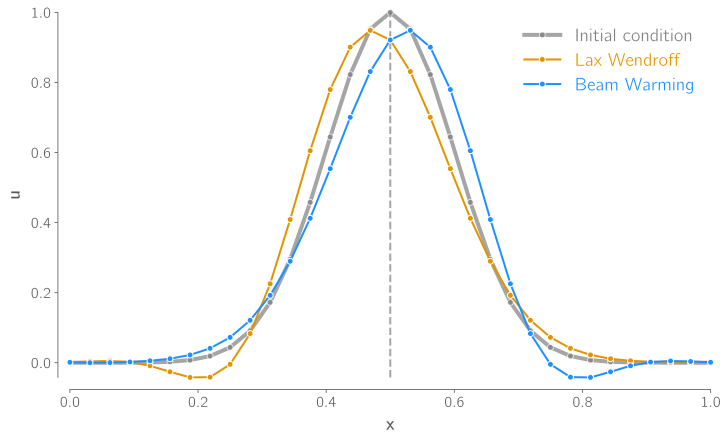

In [97]:
N = 32
a = 1
L = 1
dx = L / N
x = np.linspace(0, L, N + 1)
u0 = getInitCondition(x, L)
T = L / a

sigma = 0.5
dt = sigma * dx / a
numSteps = int(T / dt)


fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")

ax.plot(x, u0, "-o", color="gray", alpha=0.7, clip_on=False, label="Initial condition", linewidth=4)
ax.axvline(L / 2, color="gray", alpha=0.7, linestyle="--")

timeSteppers = {"Lax Wendroff": laxWendroffUpdate, "Beam Warming": beamWarmingUpdate}

for name, stepFunc in timeSteppers.items():
    uFinal = solvePeriodicIVP(u0, sigma, numSteps, stepFunc)
    ax.plot(x, uFinal, "-o", label=name, clip_on=False)

ax.legend(labelcolor="linecolor")
niceplots.adjust_spines(ax)
plt.show()


## Problem 2

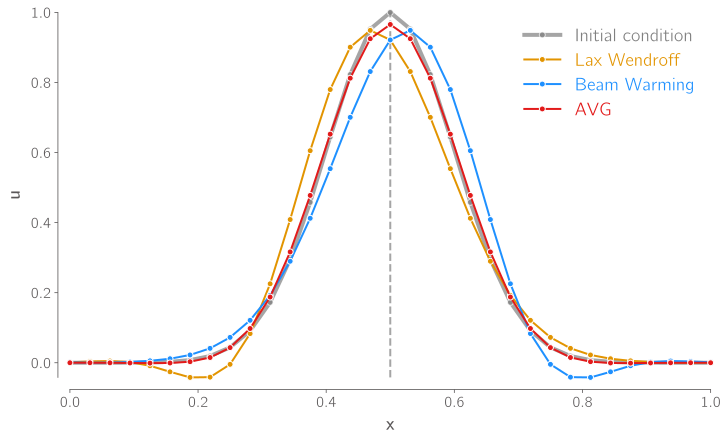

In [98]:
def avgUpdate(u, sigma):
    return 0.5 * (laxWendroffUpdate(u, sigma) + beamWarmingUpdate(u, sigma))


uFinal = solvePeriodicIVP(u0, sigma, numSteps, avgUpdate)
ax.plot(x, uFinal, "-o", label="AVG", clip_on=False)
ax.legend(labelcolor="linecolor")
fig


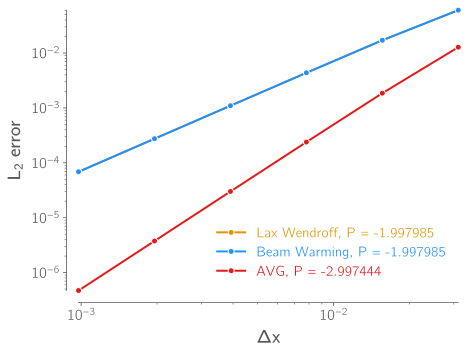

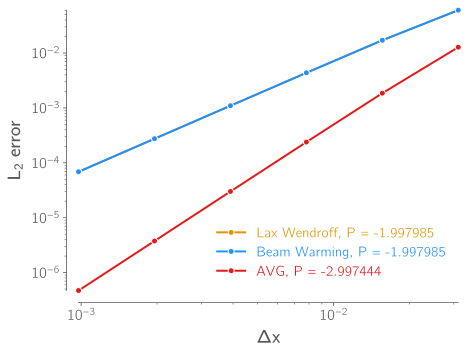

In [99]:
def computeNorm(r, ord=2):
    """Compute the "normalized" norm of an array

    Parameters
    ----------
    r : numpy.ndarray
        Vector to compute the norm of
    ord : int, optional
        Order of the norm to compute, by default 2
    """
    rFlat = r.flatten()
    return (np.sum(rFlat**ord) / len(rFlat)) ** (1 / ord)


refinementFactors = 2 ** np.arange(6)
meshSizes = N * refinementFactors
numSteps = numSteps * refinementFactors

timeSteppers = {"Lax Wendroff": laxWendroffUpdate, "Beam Warming": beamWarmingUpdate, "AVG": avgUpdate}
errors = {
    "Lax Wendroff": np.zeros(len(refinementFactors)),
    "Beam Warming": np.zeros(len(refinementFactors)),
    "AVG": np.zeros(len(refinementFactors)),
}

fig, ax = plt.subplots()
ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel(r"$L_2$ error")
ax.set_xscale("log")
ax.set_yscale("log")

for ii, (meshSize, numStep) in enumerate(zip(meshSizes, numSteps)):
    x = np.linspace(0, L, meshSize + 1)
    u0 = getInitCondition(x, L)
    for name, stepFunc in timeSteppers.items():
        uFinal = solvePeriodicIVP(u0, sigma, numStep, stepFunc)
        errors[name][ii] = computeNorm(uFinal - u0, ord=2)

for name, error in errors.items():
    rate = np.log(error[4] / error[3]) / np.log(meshSizes[4] / meshSizes[3])
    ax.plot(L / meshSizes, error, "-o", label=f"{name}, P = {rate: 2f}", clip_on=False)

ax.legend(labelcolor="linecolor", fontsize=14)
niceplots.adjust_spines(ax)
